In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

DATA_DIR = Path.cwd() / 'data'
OUTPUT_DIR = Path.cwd() / 'output'

def printUnique(df, col=None):
    if col is None:
        print(f"total index: {df.index.size}")
        print(f"unique index: {df.index.unique().size}")
    else:
        print(f"total {col}: {df[col].size}")
        print(f"unique {col}: {df[col].unique().size}")

In [2]:
"""
ADNI Patient Diagnosis
"""
df = pd.read_csv(DATA_DIR / 'DXSUM_PDXCONV_14Jun2024.csv')

# 1=Cognitively Normal; 2=Early MCI; 3=Late MCI; 4=Alzheimer's Disease; 5=Significant Memory Concern;
df_diag = df[['PHASE', 'PTID', 'EXAMDATE', 'DIAGNOSIS', 'DXAD']].dropna()
df_diag['DXAD'].replace({-4: 0}, inplace=True)
df_diag = df_diag.drop(df_diag[df_diag['DIAGNOSIS']==1].index)

printUnique(df_diag, 'PTID')
df_diag

total PTID: 2738
unique PTID: 610


,PHASE,PTID,EXAMDATE,DIAGNOSIS,DXAD
1,ADNI1,011_S_0003,2005-09-30,3.0,1.0
4,ADNI1,022_S_0007,2005-10-06,3.0,1.0
6,ADNI1,023_S_0030,2005-10-20,2.0,0.0
13,ADNI1,023_S_0042,2005-11-10,2.0,0.0
14,ADNI1,067_S_0029,2005-11-11,3.0,1.0
...,...,...,...,...,...
3861,ADNI1,082_S_1079,2008-12-01,3.0,1.0
3862,ADNI1,082_S_0832,2008-10-30,3.0,1.0
3863,ADNI1,082_S_0641,2008-03-17,3.0,1.0
3864,ADNI1,082_S_0641,2008-10-09,3.0,1.0


In [3]:
# Get unique patient IDs (PTIDs)
PTID_unique = df_diag['PTID'].unique()

ser_list_init = []
ser_list_final = []
for PTID in PTID_unique:
    df_temp = df_diag[df_diag['PTID']==PTID]
    df_temp.sort_values(by='EXAMDATE', ascending=True)

    # Set initial (earliest) visit date
    ser_list_init.append(df_temp.iloc[0])

    # Set final (latest) visit date
    query_event = df_temp[df_temp['DXAD']==1]
    if query_event.empty:
        ser_list_final.append(df_temp.iloc[-1])
    else:
        query_event.sort_values(by='EXAMDATE', ascending=True)
        ser_list_final.append(query_event.iloc[0])

# Convert series to dataframes
df_init = pd.concat(ser_list_init, axis=1).T   
df_final = pd.concat(ser_list_final, axis=1).T

#printUnique(df_init, 'PTID')
#print(df_init)
#printUnique(df_final, 'PTID')
#print(df_final)

In [4]:
# Combine dataframes on INNER JOIN
df_mci_ad = df_init.merge(df_final, on=['PTID', 'PHASE'], how='inner')

# Convert date datatypes
df_mci_ad['EXAMDATE_x'] = pd.to_datetime(df_mci_ad['EXAMDATE_x'])
df_mci_ad['EXAMDATE_y'] = pd.to_datetime(df_mci_ad['EXAMDATE_y'])

# Calculate # of days between exam dates
df_mci_ad['DAYS'] = df_mci_ad['EXAMDATE_y'] - df_mci_ad['EXAMDATE_x']
df_mci_ad['DAYS'] = pd.to_numeric(df_mci_ad['DAYS'].dt.days, downcast='integer')

#print(df_mci_ad.info())
#printUnique(df_mci_ad, 'PTID')
#df_mci_ad

In [5]:
# Set events
# 0=no progression; 1=yes progression
df_mci_ad['EVENT'] = 0
df_mci_ad.loc[(df_mci_ad['DXAD_y']==1), 'EVENT'] = 1

# Only take events with non-zero duration
df_mci_ad = df_mci_ad[df_mci_ad['DAYS'] > 0]

# Visualize survival data
print(f"No event: {df_mci_ad[df_mci_ad['EVENT']==0].index.size}")
print(f"Yes event: {df_mci_ad[df_mci_ad['EVENT']==1].index.size}")
df_mci_ad

No event: 213
Yes event: 173


,PHASE,PTID,EXAMDATE_x,DIAGNOSIS_x,DXAD_x,EXAMDATE_y,DIAGNOSIS_y,DXAD_y,DAYS,EVENT
2,ADNI1,023_S_0030,2005-10-20,2.0,0.0,2006-04-13,3.0,1.0,175,1
3,ADNI1,023_S_0042,2005-11-10,2.0,0.0,2006-11-09,3.0,1.0,364,1
5,ADNI1,007_S_0041,2005-11-14,2.0,0.0,2007-05-14,3.0,1.0,546,1
6,ADNI1,022_S_0004,2005-11-08,2.0,0.0,2008-11-18,2.0,0.0,1106,0
7,ADNI1,022_S_0044,2005-11-30,2.0,0.0,2007-01-12,2.0,0.0,408,0
...,...,...,...,...,...,...,...,...,...,...
595,ADNI1,024_S_1063,2008-12-05,2.0,0.0,2009-12-14,2.0,0.0,374,0
596,ADNI1,029_S_0843,2009-01-15,2.0,0.0,2009-11-19,2.0,0.0,308,0
597,ADNI1,941_S_1202,2009-02-24,2.0,0.0,2010-03-10,2.0,0.0,379,0
599,ADNI1,130_S_0232,2009-03-26,2.0,0.0,2010-03-12,2.0,0.0,351,0


In [6]:
"""
ADNI Gene Expression
"""
df = pd.read_csv(DATA_DIR / 'ADNI_Gene_Expression_Profile.csv', header=2, dtype='object')

# Re-format headers/index & data types
df_ge = df.drop([0,1,2,3,4,5], axis=0)
df_ge = df_ge.drop(['SubjectID', 'Unnamed: 1', 'Unnamed: 747'], axis=1)
df_ge = df_ge.dropna(axis=0)
df_ge = df_ge.rename({'Unnamed: 2': 'PTID'}, axis=1).set_index('PTID').T
df_ge = df_ge.astype('float64')

df_ge = df_ge.T.groupby(level=0).mean().T

df_ge

PTID,1-Dec,1-Mar,1-Sep,10-Mar,10-Sep,11-Mar,11-Sep,12-Sep,14-Sep,2-Mar,...,ZWILCH,ZWINT,ZXDB,ZXDB || ZXDA,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
116_S_1249,2.729,6.86125,6.9265,2.127,3.3360,2.479,6.14900,2.898,2.031667,6.6852,...,3.77150,4.0365,5.0355,2.988,4.739500,1.9045,5.31750,9.2190,7.3010,5.7490
037_S_4410,2.486,7.28150,6.9370,2.180,3.9830,2.281,6.71975,2.871,2.041333,6.3646,...,4.17300,4.4415,5.0455,3.471,4.702333,1.9265,5.38800,8.3785,6.7580,6.0935
006_S_4153,2.963,6.95275,7.0005,2.126,2.3268,2.654,6.10025,3.074,2.055667,6.4812,...,3.91275,4.6210,4.8625,2.967,4.545333,2.2315,5.62800,9.1085,7.3365,5.2615
116_S_1232,2.965,6.19750,7.0885,2.363,2.2040,2.453,6.12850,3.682,2.400667,7.2766,...,3.73800,4.4435,4.4725,3.207,4.562500,2.0545,5.46300,9.3210,7.1685,4.7340
099_S_4205,2.667,6.87700,7.1385,1.949,3.6590,2.471,6.14400,2.921,2.083667,6.3266,...,3.94600,4.5215,5.1540,3.611,4.890667,2.0405,5.64750,9.0300,7.2025,5.4575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
009_S_2381,2.770,6.41675,6.7715,2.033,2.9000,2.590,5.96975,3.317,2.335333,7.2170,...,3.50150,4.4685,4.5585,2.770,4.472167,1.9320,5.44275,9.2900,6.7035,4.7915
053_S_4557,2.881,6.43900,7.4535,2.085,2.9442,2.558,6.09925,3.149,2.311000,7.2590,...,3.58325,4.1555,4.6480,3.081,4.609833,1.9445,5.14000,9.8090,7.2810,4.7055
073_S_4300,2.877,6.63875,7.2265,1.721,3.0930,2.418,6.15175,2.897,2.028000,6.8860,...,3.63450,4.5165,4.5800,3.051,4.733500,2.0795,5.38775,9.5215,6.9825,5.0785
041_S_4014,3.185,6.58425,7.5490,1.955,2.3604,2.691,5.99650,3.139,2.375000,6.9402,...,3.68525,4.0480,4.3125,3.304,4.091000,2.0075,5.05725,9.5810,6.6865,3.8660


In [7]:
"""
ADNI Patient Demographics
"""
df = pd.read_csv(DATA_DIR / 'PTDEMOG_01Jul2024.csv')

# PTGENDER - gender
# 1=Male; 2=Female
# PTRACCAT - race
# 1=American Indian or Alaskan Native; 2=Asian; 3=Native Hawaiian or Other Pacific Islander;
# 4=Black or African American; 5=White; 6=More than one race; 7=Unknown
# PTNOTRT - retired
# 1=Yes;0=No
#df_demo = df[['PTID', 'PTGENDER', 'PTRACCAT', 'VISDATE', 'PTDOB']]
df_demo = df[['PTID', 'PTGENDER', 'VISDATE', 'PTDOB']]

df_demo['VISDATE'] = pd.to_datetime(df_demo['VISDATE'])
df_demo['PTDOB'] = pd.to_datetime(df_demo['PTDOB'])
df_demo['AGE'] = ((df_demo['VISDATE'] - df_demo['PTDOB']) / 365.25).dt.days

#df_demo["PTRACCAT"] = pd.to_numeric(df_demo["PTRACCAT"], errors="coerce")
#df_demo.loc[(df_demo['PTGENDER']<1) | (df_demo['PTRACCAT']<1)] = None
df_demo.loc[(df_demo['PTGENDER']<1)] = None
df_demo = df_demo.drop(['VISDATE', 'PTDOB'], axis=1)
df_demo = df_demo.dropna(axis=0)
df_demo = df_demo.sort_values(['AGE'], ascending=False).drop_duplicates('PTID', keep='first')


print(df_demo.dtypes)
printUnique(df_demo, 'PTID')
df_demo

PTID         object
PTGENDER    float64
AGE         float64
dtype: object
total PTID: 4216
unique PTID: 4216


C:\Users\XIAO\AppData\Local\Temp\ipykernel_14376\3720142231.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo['VISDATE'] = pd.to_datetime(df_demo['VISDATE'])
C:\Users\XIAO\AppData\Local\Temp\ipykernel_14376\3720142231.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_demo['PTDOB'] = pd.to_datetime(df_demo['PTDOB'])
C:\Users\XIAO\AppData\Local\Temp\ipykernel_14376\3720142231.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

,PTID,PTGENDER,AGE
5140,135_S_6360,1.0,104.0
2780,003_S_0907,2.0,94.0
2230,002_S_0685,2.0,94.0
4987,003_S_1122,2.0,94.0
4935,005_S_4168,1.0,94.0
...,...,...,...
1871,109_S_2288,2.0,53.0
4819,037_S_7035,2.0,53.0
4729,037_S_6992,2.0,52.0
767,041_S_0603,1.0,51.0


In [8]:
# Merge all data to create the final dataset used in survival analysis
df_surv_ge = df_mci_ad[['PTID', 'DAYS', 'EVENT']].merge(df_ge, left_on=['PTID'], right_on=df_ge.index ,how='inner')

printUnique(df_surv_ge, 'PTID')
df_surv_ge

total PTID: 142
unique PTID: 142


,PTID,DAYS,EVENT,1-Dec,1-Mar,1-Sep,10-Mar,10-Sep,11-Mar,11-Sep,...,ZWILCH,ZWINT,ZXDB,ZXDB || ZXDA,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,023_S_0042,364,1,2.798,7.24475,6.7820,2.138,2.8980,2.265,5.95150,...,3.75600,4.4405,4.8495,2.977,4.500333,1.9055,5.08575,9.1045,6.8020,5.5965
1,099_S_0051,1079,0,2.885,7.43200,6.3430,2.311,3.3958,2.421,5.70075,...,3.66100,4.6500,4.9655,3.207,4.749167,1.9930,5.52275,9.2630,7.1575,5.9955
2,007_S_0101,733,1,2.899,6.61600,7.2260,2.003,2.4216,2.510,5.65775,...,3.26300,3.4900,4.4820,2.661,4.362333,1.9840,4.99200,9.9225,7.2645,4.6080
3,127_S_0112,551,0,2.986,6.63550,6.0255,2.217,2.5594,2.358,5.96700,...,3.39125,3.9110,4.5730,2.924,4.745833,2.2160,5.41100,9.8385,7.3165,4.0530
4,007_S_0128,562,1,2.833,6.28750,7.4670,2.082,2.5086,2.619,6.11950,...,3.38950,4.1380,4.3830,2.568,4.698333,2.1310,5.28825,9.7245,7.1280,4.4290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,123_S_1300,1097,0,2.872,6.89650,6.7280,2.212,2.6900,2.461,5.87050,...,3.60175,4.3845,4.7095,2.758,4.819833,2.0740,5.51175,9.4800,7.1325,5.0850
138,024_S_1063,374,0,2.850,7.10025,7.4770,1.964,2.7232,2.548,6.31550,...,3.88800,4.2140,4.6320,3.648,4.576333,1.9285,5.54775,9.0470,7.1225,5.2960
139,029_S_0843,308,0,2.781,7.17225,6.9690,1.970,3.4958,2.455,5.91600,...,4.11375,4.9800,4.7120,2.927,4.833167,1.8930,5.43975,8.6400,6.8525,5.5080
140,941_S_1202,379,0,2.991,6.25725,7.2380,2.107,2.3918,2.372,5.88025,...,3.58925,4.4250,4.4035,2.724,4.606000,1.9405,5.20850,9.7245,7.0540,4.6830


In [81]:
from sklearn.feature_selection import VarianceThreshold

# Remove all features that are either one or zero (on or off) in more than 70% (THRESHOLD) of the samples
# Take top & bottom 30% of features
THRESHOLD = 0.7
X_genes = df_surv_ge.drop(['PTID', 'DAYS', 'EVENT'], axis=1).to_numpy()

selector = VarianceThreshold(threshold=(THRESHOLD * (1 - THRESHOLD)))
selector.fit(X_genes)
X_sel = df_surv_ge[df_surv_ge.columns[selector.get_support(indices=True)]]

print(f"{df_surv_ge.columns.size} columns")
print(f"{X_sel.columns.size} columns")

20095 columns
1873 columns


In [82]:
### Univariate cox regression
from lifelines import CoxPHFitter

data = []
#gene_col = df_surv_ge.columns.drop(['PTID', 'DAYS', 'EVENT', 'PTGENDER', 'PTRACCAT', 'AGE']).unique()
gene_col = X_sel.columns.unique()

cph = CoxPHFitter()
for col in tqdm(gene_col):
    cph.fit(df_surv_ge[[col, 'DAYS', 'EVENT']], duration_col='DAYS', event_col='EVENT')
    data.append(cph.summary)

cph_summary = pd.concat(data, ignore_index=True, sort=False)
cph_summary = cph_summary.set_index(gene_col)

100%|██████████████████████████████████████████████████████████████████████████████| 1873/1873 [00:53<00:00, 35.19it/s]


In [83]:
cph_significant = cph_summary[cph_summary['p'] < 0.05]

print('Univariate COX Regression\n')
print(f"{cph_summary.index.size} genes (all)")
print(f"{cph_significant.index.size} genes (p<0.05)\n")
#cph_summary.head()
#cph_significant.head()

print(list(cph_significant.index))

Univariate COX Regression

1873 genes (all)
203 genes (p<0.05)

['ADCY10', 'ADIPOR2', 'ADM5', 'AGPAT4', 'ALPK1', 'AMBP', 'AMHR2', 'AMZ1', 'ANAPC4', 'ANGPTL5', 'ARHGEF37', 'ASF1A', 'BANP', 'BCL11A', 'BHMT', 'BLK', 'BTN3A2 || BTN3A1', 'C3ORF33', 'C5ORF24', 'CAPN1', 'CASP2', 'CAV3', 'CCDC109B', 'CCDC117', 'CCDC144B || CCDC144CP || CCDC144A', 'CCNE1', 'CD163L1', 'CD69', 'CEACAM3', 'CEP120', 'CETP', 'CGN', 'CLDN19', 'CLDN2', 'CLEC3A', 'COL15A1', 'CPXM2', 'CXCL17', 'DDX54', 'DENND4C', 'DNASE1', 'DPH6', 'DSG3', 'DYNLRB1', 'EIF1AX', 'EN2', 'ENSG00000211625 || ENSG00000239951', 'ENSG00000211638', 'ENSG00000211899 || ENSG00000233855', 'ENSG00000249642', 'EPHB3', 'ETV7', 'FAM175A', 'FAM19A3', 'FAM35BP || FAM35DP || FAM35A', 'FBXO5', 'FCGR1C || FCGR1A || FCGR1B', 'FCN3', 'FLRT2', 'GABRR3', 'GALNT16', 'GAS7', 'GBA || GBAP1', 'GBGT1', 'GCFC2', 'GHR', 'GLMN', 'GP2', 'GPR62', 'GPR78', 'GSAP', 'GSTCD', 'HADH', 'HEPACAM', 'HIST1H4H', 'HLA-DOB || ENSG00000243496', 'HPCA', 'HRH2', 'IFNL2 || IFNL3', 'IGHV5

In [84]:
### LASSO cox regression w/ 5-Fold CV
from sklearn.model_selection import KFold
from lifelines import CoxPHFitter

idx = list(cph_significant.index)
#idx = list(df_ge.columns)
#idx.extend(['PTGENDER', 'PTRACCAT', 'AGE'])
X = df_surv_ge[idx]

idx.extend(['DAYS','EVENT'])
data_lasso = df_surv_ge[idx]

lambdas = np.logspace(-4,0,20)
score_list = []

kf = KFold(n_splits=5)
for _lambda in tqdm(lambdas):
    scores = []
    for i, (train_index, val_index) in enumerate(kf.split(X)):
        # Retrieve data subset from CV
        X_train, X_val = data_lasso.iloc[train_index], data_lasso.iloc[val_index]

        # Fit model
        cph_lasso = CoxPHFitter(penalizer=_lambda, l1_ratio=1)
        cph_lasso.fit(X_train, 'DAYS', 'EVENT')

        # Calculate score
        score = cph_lasso.score(df=X_val, scoring_method='concordance_index')
        scores.append(score)
        
    score_list.append(np.mean(scores))
    
lambda_scores = pd.DataFrame({'lambda': lambdas, 'score': score_list})
best_score = lambda_scores.sort_values(by='score', ascending=False).iloc[0]

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\XIAO\miniconda3\envs\ml\lib\site-packages\lifelines\utils\__init__.py:992: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

  warnings.warn(warning_text, ConvergenceWarning)
C:\Users\XIAO\miniconda3\envs\ml\lib\site-packages\lifelines\fitters\coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
C:\Users\XIAO\miniconda3\envs\ml\lib\site-packages\lifelines\utils\__init__.py:992: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

  warnings.warn(warni

      lambda     score
0   0.000100  0.617378
1   0.000162  0.621680
2   0.000264  0.627486
3   0.000428  0.632263
4   0.000695  0.640298
5   0.001129  0.657514
6   0.001833  0.676624
7   0.002976  0.704448
8   0.004833  0.702298
9   0.007848  0.705355
10  0.012743  0.707105
11  0.020691  0.711775
12  0.033598  0.697733
13  0.054556  0.621420
14  0.088587  0.531873
15  0.143845  0.415533
16  0.233572  0.649886
17  0.379269  0.654677
18  0.615848  0.655452
19  1.000000  0.655452

Best Hyperparameters
lambda: 0.0206913808111479
score: 0.7117749049425304



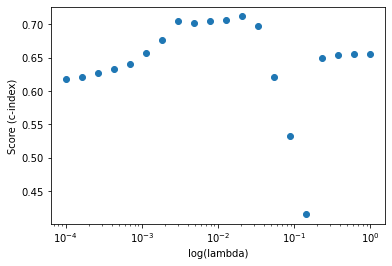

In [85]:
print(lambda_scores)
print(f"\nBest Hyperparameters\nlambda: {best_score['lambda']}\nscore: {best_score['score']}\n")

import matplotlib.pyplot as plt

plt.scatter(lambda_scores['lambda'], lambda_scores['score'])
plt.xscale('log')
plt.xlabel('log(lambda)')
plt.ylabel('Score (c-index)')

plt.show()

In [86]:
cph_lasso = CoxPHFitter(penalizer=best_score['lambda'], l1_ratio=1.0)
cph_lasso.fit(data_lasso, "DAYS", "EVENT")

<lifelines.CoxPHFitter: fitted with 142 total observations, 88 right-censored observations>

In [87]:
cph_lasso.summary.sort_values(by='p', ascending=True)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
SPERT,-6.270553e+00,0.001891,1.609420,-9.424958,-3.116149,0.000081,0.044328,0.0,-3.896158,0.000098,13.320830
NT5C1B-RDH14 || RDH14,1.872196e+00,6.502563,0.704990,0.490442,3.253951,1.633037,25.892444,0.0,2.655636,0.007916,6.981031
DYNLRB1,5.582541e+00,265.746019,2.580573,0.524710,10.640372,1.689969,41788.309788,0.0,2.163295,0.030519,5.034172
SPON1,-2.151123e+00,0.116353,1.202006,-4.507012,0.204766,0.011031,1.227238,0.0,-1.789611,0.073517,3.765787
ANGPTL5,-4.645604e+00,0.009604,2.793780,-10.121312,0.830105,0.000040,2.293558,0.0,-1.662838,0.096345,3.375649
...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000249642,1.551766e-08,1.000000,0.000865,-0.001696,0.001696,0.998305,1.001698,0.0,0.000018,0.999986,0.000021
ZNF84,2.769129e-09,1.000000,0.000209,-0.000409,0.000409,0.999591,1.000410,0.0,0.000013,0.999989,0.000015
LOC101929103 || MXRA8,-6.023472e-09,1.000000,0.000495,-0.000970,0.000970,0.999030,1.000971,0.0,-0.000012,0.999990,0.000014


In [88]:
cph_lasso_sig = cph_lasso.summary[(cph_lasso.summary['p']<0.05)]
print(f"significant genes: {cph_lasso_sig.index.size}")
cph_lasso_sig

significant genes: 3


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
DYNLRB1,5.582541,265.746019,2.580573,0.524710,10.640372,1.689969,41788.309788,0.0,2.163295,0.030519,5.034172
NT5C1B-RDH14 || RDH14,1.872196,6.502563,0.704990,0.490442,3.253951,1.633037,25.892444,0.0,2.655636,0.007916,6.981031
SPERT,-6.270553,0.001891,1.609420,-9.424958,-3.116149,0.000081,0.044328,0.0,-3.896158,0.000098,13.320830


In [89]:
# Add demographics data
df_surv_ge_demo = df_demo.merge(df_surv_ge, on='PTID', how='inner')
df_surv_ge_demo = df_surv_ge_demo.astype({'PTGENDER': 'category'})

printUnique(df_surv_ge_demo, 'PTID')
df_surv_ge_demo

total PTID: 142
unique PTID: 142


,PTID,PTGENDER,AGE,DAYS,EVENT,1-Dec,1-Mar,1-Sep,10-Mar,10-Sep,...,ZWILCH,ZWINT,ZXDB,ZXDB || ZXDA,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,003_S_1122,2.0,94.0,1112,0,2.642,7.26750,6.4450,1.930,3.4722,...,3.84550,4.8145,4.9975,3.309,4.803333,1.9840,5.73900,8.4445,6.8310,5.8960
1,128_S_0138,1.0,92.0,365,0,2.760,6.59800,7.4960,2.049,2.9606,...,3.71025,4.1995,4.7665,3.258,4.779333,2.0890,5.24675,9.7805,7.3335,4.7640
2,141_S_0697,1.0,92.0,1259,1,3.027,5.45450,6.8085,2.547,2.1926,...,3.77175,4.8060,4.3705,2.779,3.962333,2.0665,5.27200,9.7790,6.3925,4.6130
3,052_S_1352,1.0,91.0,801,0,2.959,6.92725,6.5360,2.111,3.3436,...,3.69650,4.8150,4.8550,2.761,4.693333,2.1380,5.55400,8.5000,6.9200,5.3690
4,051_S_1131,1.0,91.0,1147,0,2.814,6.58350,6.9440,1.977,2.6666,...,3.47900,3.7490,4.5645,2.818,4.752167,2.1430,5.30950,9.8015,7.3500,4.5435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,136_S_0107,2.0,66.0,1584,0,2.903,6.51325,7.1280,2.121,2.7378,...,3.89125,4.6875,4.6900,3.560,4.543167,1.9345,5.43500,8.8850,6.8835,5.3075
138,003_S_1057,2.0,66.0,1389,1,2.830,6.40325,7.1285,1.998,2.9308,...,4.22650,4.3590,4.9715,2.612,4.079333,2.1575,5.38550,9.3970,6.4895,5.9325
139,051_S_1072,2.0,65.0,1184,0,2.946,6.42425,7.1450,2.088,2.4460,...,3.33575,4.4200,4.5100,2.966,4.621500,1.9520,5.60050,9.6590,7.4095,5.0995
140,128_S_1406,2.0,65.0,1657,0,3.017,6.87225,6.6255,2.065,4.1264,...,4.46675,3.9925,5.1530,3.318,4.782667,1.8910,5.29175,9.2885,7.2555,5.9175


In [90]:
"""
Cox regression - iter 2
"""
idx = list(cph_lasso_sig.index)
idx.extend(['PTGENDER', 'AGE'])
X = df_surv_ge_demo[idx]

idx.extend(['DAYS','EVENT'])
data_cox = df_surv_ge_demo[idx]

# Fit model
cph_cox = CoxPHFitter()
cph_cox.fit(data_cox, 'DAYS', 'EVENT')

<lifelines.CoxPHFitter: fitted with 142 total observations, 88 right-censored observations>

In [91]:
cph_cox.summary.sort_values(by='p', ascending=True)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
SPERT,-2.795204,0.061102,0.783042,-4.329938,-1.260470,0.013168,0.283521,0.0,-3.569673,0.000357,11.450062
DYNLRB1,2.679153,14.572751,1.169819,0.386351,4.971956,1.471601,144.308826,0.0,2.290230,0.022008,5.505829
NT5C1B-RDH14 || RDH14,-0.371299,0.689838,0.223685,-0.809714,0.067116,0.444985,1.069420,0.0,-1.659918,0.096931,3.366897
AGE,-0.020500,0.979709,0.018383,-0.056529,0.015529,0.945039,1.015651,0.0,-1.115181,0.264773,1.917172
PTGENDER,0.311867,1.365973,0.303672,-0.283318,0.907052,0.753280,2.477010,0.0,1.026988,0.304426,1.715836


In [92]:
# Write to file
#OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
#cph_cox.summary.to_csv(OUTPUT_DIR / 'risk_score_transcriptomics_comparison.csv')

In [93]:
df = pd.read_csv(OUTPUT_DIR / 'risk_score_transcriptomics_comparison.csv')
df_model = df

df_model

,covariate,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
0,DYNLRB1,2.679153,14.572751,1.169819,0.386351,4.971956,1.471601,144.308826,0.0,2.290230,0.022008,5.505829
1,NT5C1B-RDH14 || RDH14,-0.371299,0.689838,0.223685,-0.809714,0.067116,0.444985,1.069420,0.0,-1.659918,0.096931,3.366897
2,SPERT,-2.795204,0.061102,0.783042,-4.329938,-1.260470,0.013168,0.283521,0.0,-3.569673,0.000357,11.450062
3,PTGENDER,0.311867,1.365973,0.303672,-0.283318,0.907052,0.753280,2.477010,0.0,1.026988,0.304426,1.715836
4,AGE,-0.020500,0.979709,0.018383,-0.056529,0.015529,0.945039,1.015651,0.0,-1.115181,0.264773,1.917172


<Axes: xlabel='Coefficient (95% CI)'>

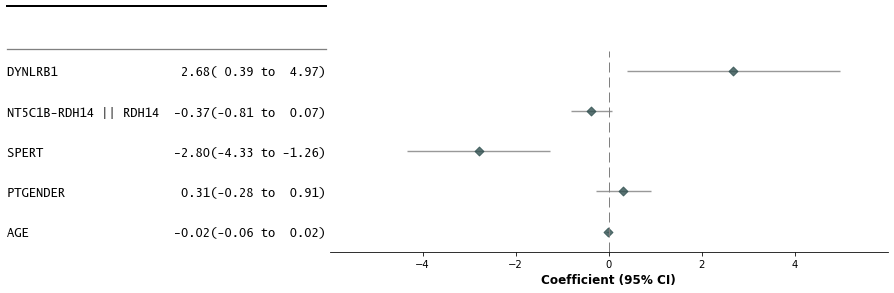

In [94]:
import forestplot as fp

fp.forestplot(
    dataframe=df_model,  # the dataframe with results data
    estimate="coef",  # col containing estimated effect size 
    ll="coef lower 95%",
    hl="coef upper 95%",
    varlabel="covariate",  # column containing variable label
    xlabel="Coefficient (95% CI)",  # x-label title
    annote=["est_ci"],
    annoteheaders=["Est. (95% Conf. Int.)"],
    table=True,
    xticks=[-4,-2,0,2,4],
    **{
        'figsize': (10,4),
        'xlim': (-6, 6),
        'marker': 'D',
        "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
        "xlinecolor": "#808080",  # gray color for x-reference line
    },
)

#plt.savefig(OUTPUT_DIR / 'forest_plot_transcriptomics2.png', dpi=300, bbox_inches='tight')

<Axes: xlabel='Coefficient (95% CI)'>

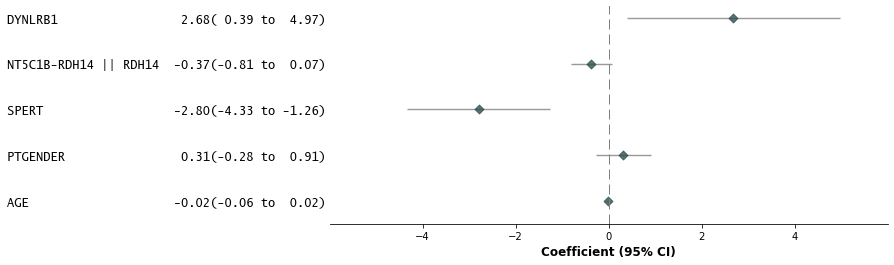

In [95]:
import forestplot as fp

fp.forestplot(
    dataframe=df_model,  # the dataframe with results data
    estimate="coef",  # col containing estimated effect size 
    ll="coef lower 95%",
    hl="coef upper 95%",
    varlabel="covariate",  # column containing variable label
    xlabel="Coefficient (95% CI)",  # x-label title
    xticks=[-4,-2,0,2,4],
    **{
        'figsize': (10,4),
        'xlim': (-6, 6),
        'marker': 'D',
        "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
        "xlinecolor": "#808080",  # gray color for x-reference line
    },
)

#plt.savefig(OUTPUT_DIR / 'forest_plot_transcriptomics.png', dpi=300, bbox_inches='tight')

In [96]:
"""
Risk Score Calculation
"""

features = list(df_model['covariate'])
df_patients = df_surv_ge_demo[features + ['PTID', 'EVENT', 'DAYS']]

print(df_patients.columns)

print(f"feature size:\t{df_patients.drop(['PTID', 'EVENT', 'DAYS'], axis=1).columns.size}")
print(f"coef size:\t{df_model['coef'].index.size}")

Index(['DYNLRB1', 'NT5C1B-RDH14 || RDH14', 'SPERT', 'PTGENDER', 'AGE', 'PTID',
       'EVENT', 'DAYS'],
      dtype='object')
feature size:	5
coef size:	5


In [97]:
values = df_patients.drop(['PTID', 'EVENT', 'DAYS'], axis=1)
coefs = df_model['coef'].to_numpy()
df_patients['pred'] = values.dot(coefs)

df_patients['pred'].describe()
#df_patients['pred']

count    142.000000
mean       8.067345
std        0.667243
min        6.493447
25%        7.519961
50%        8.119832
75%        8.512133
max       10.101894
Name: pred, dtype: float64

median:		8.11983187831791
less than:	71
equal to:	0
greater than:	71


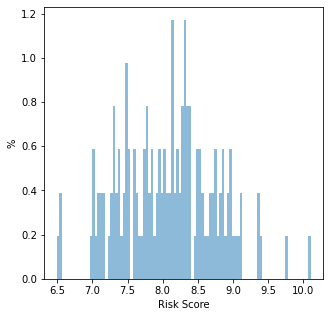

In [98]:
median = df_patients['pred'].median()
print(f"median:\t\t{median}")
print(f"less than:\t{df_patients[df_patients['pred']<median].index.size}")
print(f"equal to:\t{df_patients[df_patients['pred']==median].index.size}")
print(f"greater than:\t{df_patients[df_patients['pred']>median].index.size}")

import statsmodels.api as sm
import matplotlib.pylab as py
import matplotlib.pyplot as plt

kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True)
fig = plt.figure(figsize=(5,5))
plt.hist(df_patients['pred'].astype('float'), **kwargs)

plt.gca().set(ylabel='%', xlabel='Risk Score')
#plt.savefig('gene_expr_dist.jpg', bbox_inches='tight', dpi=300)
plt.show()

In [99]:
df_patients.loc[df_patients['pred'] < median, 'risk'] = 'Low Risk'
df_patients.loc[df_patients['pred'] > median, 'risk'] = 'High Risk'

In [100]:
from lifelines.statistics import logrank_test

ix = df_patients['risk'] == 'Low Risk'
T_exp, E_exp = df_patients.loc[ix, 'DAYS'], df_patients.loc[ix, 'EVENT']
T_con, E_con = df_patients.loc[~ix, 'DAYS'], df_patients.loc[~ix, 'EVENT']

results = logrank_test(T_exp, T_con, event_observed_A=E_exp, event_observed_B=E_con)
print(results.p_value)
print(results.test_statistic)
results.print_summary()

0.002082051006967429
9.475755704511467


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           9.48 <0.005      8.91

Text(0, 0.15, 'p-value =  0.002082')

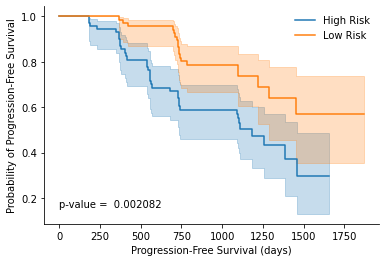

In [101]:
from lifelines import KaplanMeierFitter

ax = plt.subplot(111)
kmf = KaplanMeierFitter()

for name, grouped_df in df_patients.groupby('risk'):
    kmf.fit(grouped_df["DAYS"], grouped_df["EVENT"], label=name)
    kmf.plot_survival_function(ax=ax)

# Adjust plt
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(frameon=False)

ax.set_xlabel("Progression-Free Survival (days)")
ax.set_ylabel("Probability of Progression-Free Survival")

ax.text(0, 0.15, f"p-value = {results.p_value: .6f}",
        horizontalalignment="left",
        verticalalignment="bottom")

# Print to PNG file
#ax.get_figure().savefig(OUTPUT_DIR / 'km_plot_transcriptomics.png', bbox_inches='tight', dpi=300)

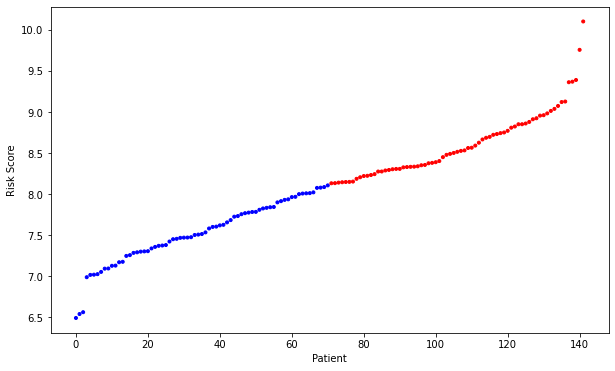

In [102]:
df_temp = df_patients.sort_values(by='pred', ascending=True)
colour = df_temp['risk'].map({'Low Risk': 'blue', 'High Risk': 'red'})
x = np.arange(df_patients['pred'].size)
y = df_temp['pred']

kwargs = dict(marker='.', c=colour)
fig = plt.figure(figsize=(10,6))
plt.scatter(x, y, **kwargs)
plt.xlabel('Patient')
plt.ylabel('Risk Score')
plt.show()